In [1]:
%matplotlib inline

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pymap3d
import scipy.io.wavfile

plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 14

In [2]:
ea4gpz = (40.595862421414076, -3.6990804605268175, 800)
beacon = (40.7105565750896, -4.140334075927956, 1511)

qo100_azimuth = 138.84
qo100_elevation = 34.10

# METAR:
# LEMD 051630Z 12003KT 7000 3000N VCSH SCT020CB BKN050 21/12 Q1022 TEMPO 3000 TSRA SCT030CB
# We take 5000 ft = 914.4 m
rain_top = 1524

# half-power half beam-width
hphb = 0.88

horiz_dist_to_top = rain_top / np.tan(np.deg2rad(qo100_elevation))
slant_dist_to_top = rain_top / np.sin(np.deg2rad(qo100_elevation))
slant_dist_to_top

2718.326792782674

In [3]:
mid_enu = pymap3d.aer2enu(qo100_azimuth, qo100_elevation, slant_dist_to_top/2)
top_enu = pymap3d.aer2enu(qo100_azimuth, qo100_elevation, slant_dist_to_top)
top = pymap3d.enu2geodetic(*top_enu, *ea4gpz)
mid = pymap3d.enu2geodetic(*mid_enu, *ea4gpz)
top_left = pymap3d.enu2geodetic(
    *pymap3d.aer2enu(qo100_azimuth - hphb, qo100_elevation, slant_dist_to_top),
    *ea4gpz)
top_right = pymap3d.enu2geodetic(
    *pymap3d.aer2enu(qo100_azimuth + hphb, qo100_elevation, slant_dist_to_top),
    *ea4gpz)
clear_right = pymap3d.enu2geodetic(
    *pymap3d.aer2enu(qo100_azimuth + hphb, qo100_elevation, 100),
    *ea4gpz)

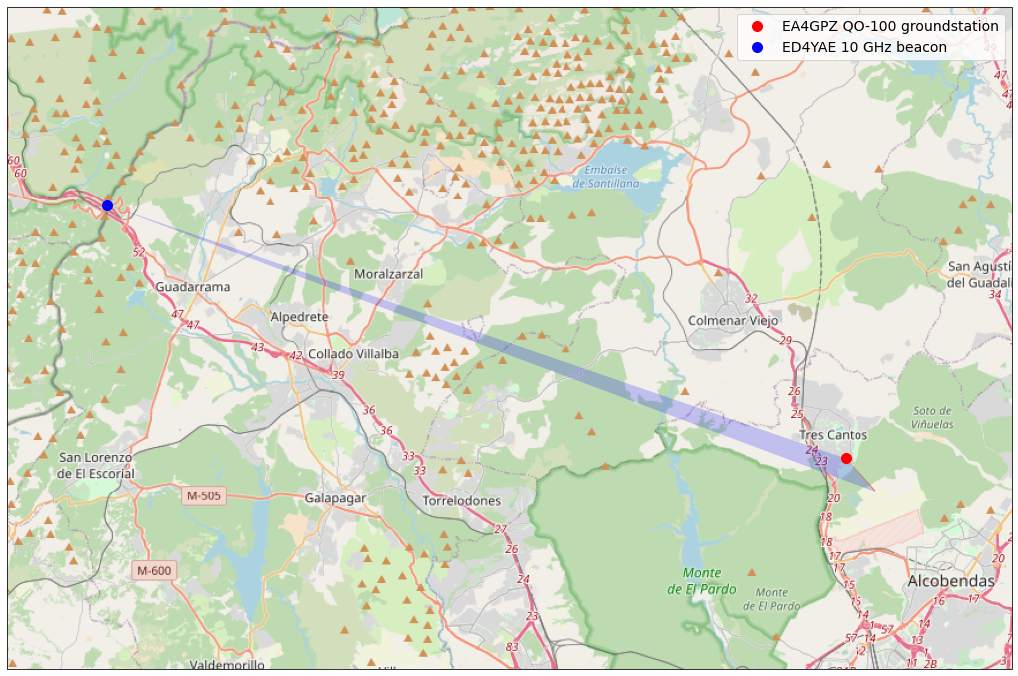

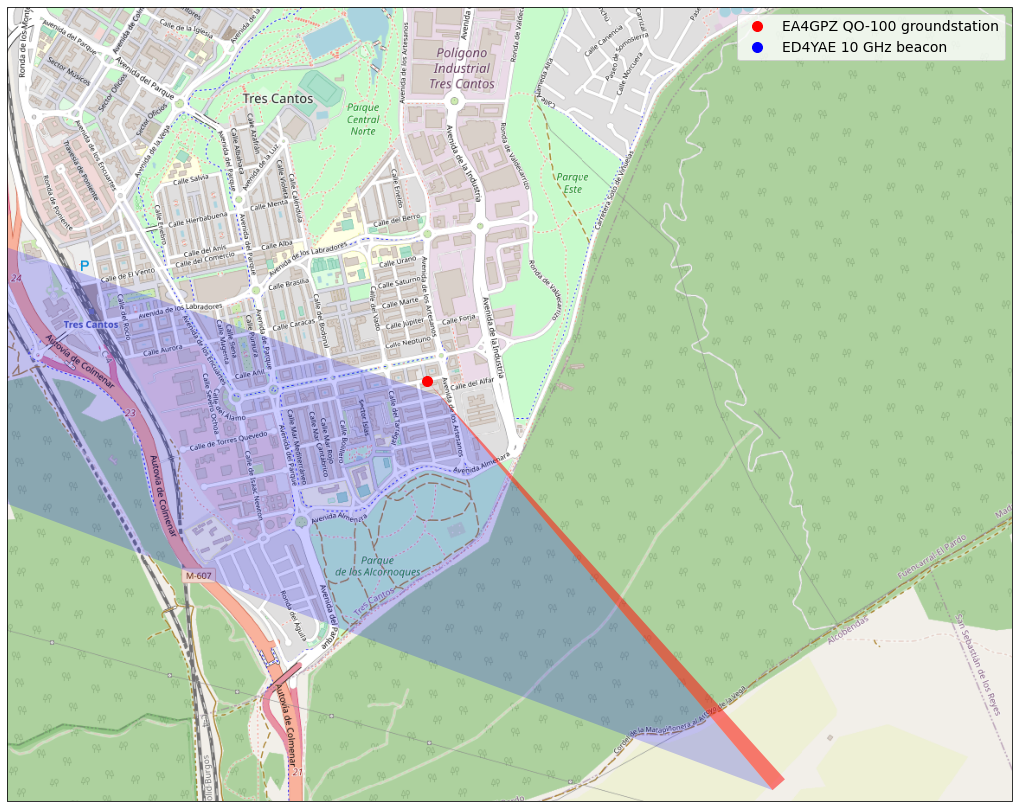

In [4]:
imagery = OSM()
extents = [(-4.2, -3.6, 40.5, 40.8),
           (-3.72, -3.67, 40.58, 40.61)]
img_sizes = [11, 15]

for extent, img_size in zip(extents, img_sizes):
    plt.figure(figsize=(18, 18), facecolor='w')
    ax = plt.axes(projection=imagery.crs)
    ax.set_extent(extent)
    ax.add_patch(mpatches.Polygon(
        xy=[[beacon[1], beacon[0]], [top_right[1], top_right[0]], [clear_right[1], clear_right[0]]],
        facecolor='blue', alpha=0.2,
        transform=ccrs.Geodetic()))
    ax.add_patch(mpatches.Polygon(
        xy=[[ea4gpz[1], ea4gpz[0]], [top_left[1], top_left[0]], [top_right[1], top_right[0]]],
        facecolor='red', alpha=0.5,
        transform=ccrs.Geodetic()))
    plt.plot(ea4gpz[1], ea4gpz[0], 'o', markersize=10,
             color='red', transform=ccrs.Geodetic(),
             label='EA4GPZ QO-100 groundstation')
    plt.plot(beacon[1], beacon[0], 'o', markersize=10,
             color='blue', transform=ccrs.Geodetic(),
             label='ED4YAE 10 GHz beacon')
    ax.add_image(imagery, img_size)
    plt.legend()

In [5]:
beacon_enu = pymap3d.geodetic2enu(*beacon, *ea4gpz)
beacon_dist = np.sqrt(np.sum(np.array(beacon_enu)**2))
beacon_dist

39445.83052429537

In [6]:
scatter_angle = np.arccos(
    np.sum(np.array(mid_enu) * np.array(beacon_enu)) / np.sqrt(
        np.sum(np.array(mid_enu)**2) * np.sum(np.array(beacon_enu)**2)))
np.rad2deg(scatter_angle)

135.21316033612936

In [7]:
fs, x = scipy.io.wavfile.read('/home/daniel/ed4yae-10ghz-rainscatter.wav',
                              mmap=True)

In [8]:
T = 17*60
N = fs * T

In [9]:
Nfft = 2**11
y = x[:N]
y = y[:y.size//Nfft*Nfft].reshape((-1, Nfft))
w = np.blackman(Nfft)
f = np.fft.rfft(w * y)

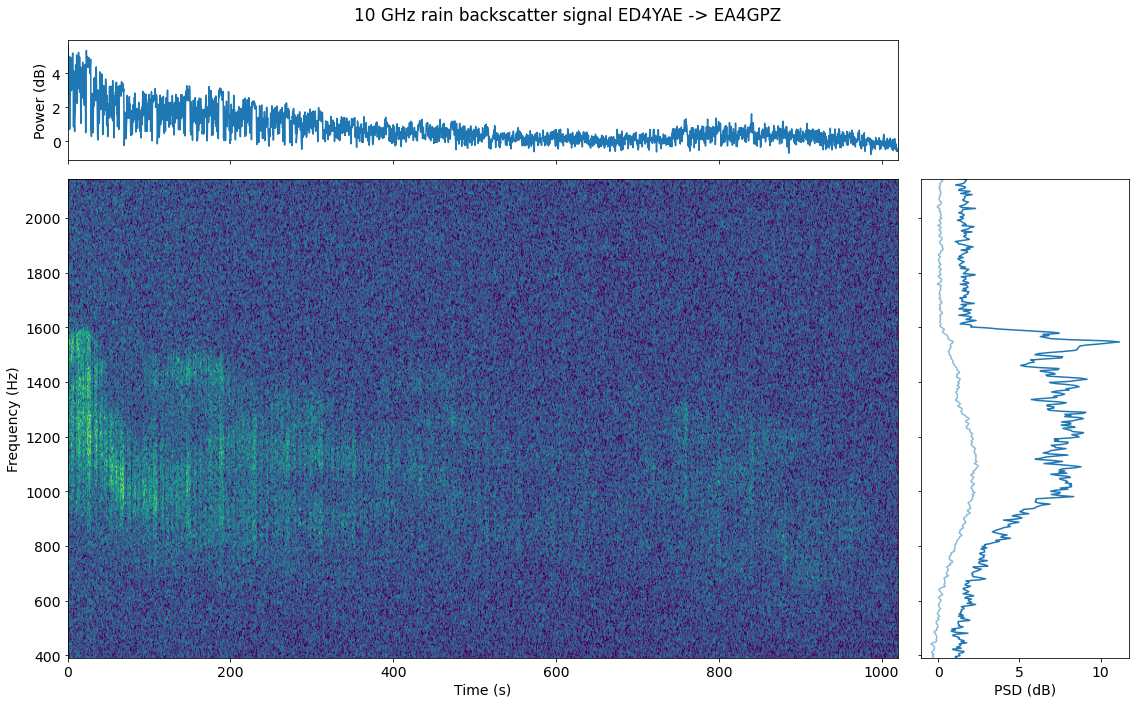

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10),
                        sharex='col', sharey='row',
                        gridspec_kw={'width_ratios': [4, 1],
                                     'height_ratios': [1, 4]})
axs[0, 1].axis('off')

fsel = slice(100, 550)
f_axis = np.fft.rfftfreq(Nfft, 1/fs)[fsel]
t_axis = np.arange(f.shape[0]) * Nfft / fs

pwr = np.average(np.abs(f[:, fsel])**2, axis=1)
k = 2
pwr = np.convolve(pwr, np.ones(k)/k)[k//2:-k//2]
psd_block = 50
psd = np.average(np.abs(f[:, fsel])**2, axis=0)
psd_max = np.abs(f[:f.shape[0]//psd_block*psd_block, fsel])**2
psd_max = psd_max.reshape((-1, psd_block, psd_max.shape[-1]))
psd_max = np.max(np.average(psd_max, axis=1), axis=0)
axs[0, 0].plot(t_axis[:pwr.size], 10*np.log10(pwr) - 72)
axs[1, 0].imshow(20*np.log10(np.abs(f[:, fsel].T[::-1])),
                 aspect='auto', vmin=65, vmax=85,
                 extent=[t_axis[0], t_axis[-1],
                         f_axis[0], f_axis[-1]])
axs[1, 1].plot(10*np.log10(psd) - 72, f_axis, color='C0', alpha=0.5)
axs[1, 1].plot(10*np.log10(psd_max) - 72, f_axis, color='C0')
axs[0, 0].set_ylabel('Power (dB)')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Frequency (Hz)')
axs[1, 1].set_xlabel('PSD (dB)')
plt.suptitle('10 GHz rain backscatter signal ED4YAE -> EA4GPZ')
plt.tight_layout();